100%|██████████| 60/60 [04:50<00:00,  4.84s/it]



1. Overall Test Accuracy: 87.99%

Per-action Accuracy:
calling: 78.57%
clapping: 80.95%
cycling: 99.21%
dancing: 93.65%
drinking: 90.48%
eating: 96.03%
fighting: 83.33%
hugging: 88.10%
laughing: 86.51%
listening_to_music: 84.92%
running: 91.27%
sitting: 84.13%
sleeping: 92.86%
texting: 84.92%
using_laptop: 84.92%

2. Similarity Matrix (%):
Rows: True Action, Columns: Predicted Action Confidence

True calling:
  calling: 76.88%
  clapping: 0.06%
  cycling: 0.15%
  dancing: 0.16%
  drinking: 1.57%
  eating: 0.13%
  fighting: 0.01%
  hugging: 0.27%
  laughing: 1.60%
  listening_to_music: 5.83%
  running: 0.45%
  sitting: 3.89%
  sleeping: 0.93%
  texting: 3.91%
  using_laptop: 4.17%

True clapping:
  calling: 0.22%
  clapping: 80.04%
  cycling: 0.01%
  dancing: 2.65%
  drinking: 0.25%
  eating: 1.42%
  fighting: 0.88%
  hugging: 1.24%
  laughing: 4.67%
  listening_to_music: 1.43%
  running: 0.13%
  sitting: 4.50%
  sleeping: 0.04%
  texting: 1.24%
  using_laptop: 1.27%

True cycling:
  c

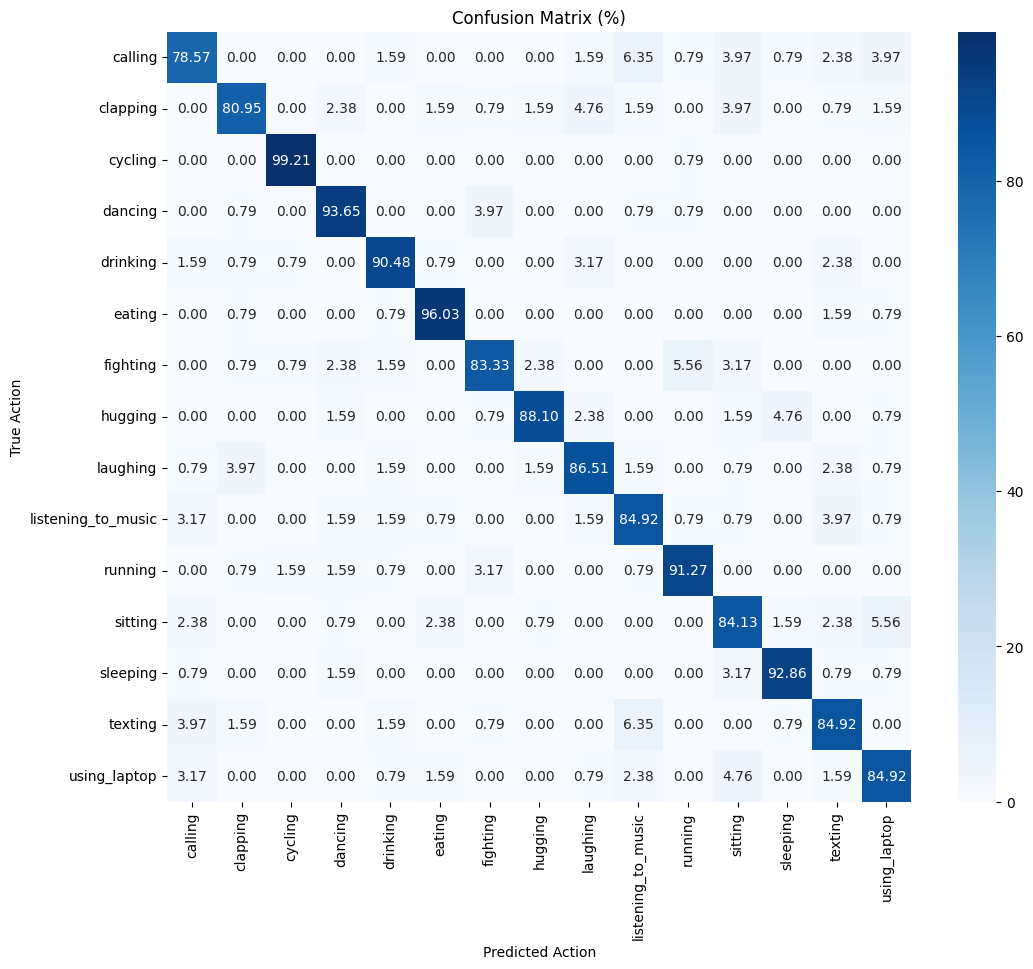


Confusion Analysis (Significant Misclassifications, >5%):
True 'calling' predicted as 'listening_to_music': 6.35%
True 'fighting' predicted as 'running': 5.56%
True 'sitting' predicted as 'using_laptop': 5.56%
True 'texting' predicted as 'listening_to_music': 6.35%


In [2]:
import os
import torch
import torch.nn as nn
import cv2
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import timm
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define action classes
ACTION_CLASSES = [
    'calling', 'clapping', 'cycling', 'dancing', 'drinking',
    'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music',
    'running', 'sitting', 'sleeping', 'texting', 'using_laptop'
]

# Define image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define dataset class
class ActionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        for label, action in enumerate(ACTION_CLASSES):
            action_dir = os.path.join(root_dir, action)
            if os.path.exists(action_dir):
                for img_name in os.listdir(action_dir):
                    img_path = os.path.join(action_dir, img_name)
                    self.data.append((img_path, label))
            else:
                print(f"Warning: Directory {action_dir} does not exist and will be skipped.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        return image, label, img_path

# Define the model class
class ActionRecognitionModel(nn.Module):
    def __init__(self, num_classes=15):
        super(ActionRecognitionModel, self).__init__()
        self.vit = timm.create_model("vit_base_patch16_224", pretrained=False)
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ActionRecognitionModel(num_classes=len(ACTION_CLASSES)).to(device)

# Adjust the model's head to match the checkpoint's dimensions
checkpoint = torch.load("../file_final/model_ver2.pth", map_location=device)
checkpoint_num_classes = checkpoint["model_state_dict"]["vit.head.weight"].size(0)
if checkpoint_num_classes != len(ACTION_CLASSES):
    model.vit.head = nn.Linear(model.vit.head.in_features, checkpoint_num_classes).to(device)

model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Define the test dataset and dataloader
test_dataset = ActionDataset(root_dir=r"../file_final/Structured/test", transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model
correct = 0
total = 0
y_true = []
y_pred = []
action_correct = {action: 0 for action in ACTION_CLASSES}
action_total = {action: 0 for action in ACTION_CLASSES}
confidence_sums = np.zeros((len(ACTION_CLASSES), len(ACTION_CLASSES)))  # For similarity analysis

with torch.no_grad():
    for images, labels, img_paths in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Collect true and predicted labels
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        # Accumulate confidence scores for similarity
        for prob, label in zip(probabilities, labels):
            confidence_sums[label.item()] += prob.cpu().numpy()

        # Per-image statistics
        for label, pred in zip(labels, predicted):
            action_total[ACTION_CLASSES[label.item()]] += 1
            if label == pred:
                action_correct[ACTION_CLASSES[label.item()]] += 1

# 1. Tỷ lệ chính xác (%)
if total == 0:
    print("Không có dữ liệu để tính accuracy.")
    accuracy = 0
else:
    accuracy = (correct / total) * 100

print(f"\n1. Overall Test Accuracy: {accuracy:.2f}%")

print("\nPer-action Accuracy:")
for action in ACTION_CLASSES:
    if action_total[action] > 0:
        acc = (action_correct[action] / action_total[action]) * 100
        print(f"{action}: {acc:.2f}%")
    else:
        print(f"{action}: No samples")

# 2. Độ giống nhau (%)
# Normalize confidence sums to get average confidence per true class
action_total_values = np.array([action_total.get(action, 0) for action in ACTION_CLASSES])
action_total_values = np.maximum(action_total_values, 1)  # Avoid division by zero
confidence_avg = confidence_sums / action_total_values.reshape(-1, 1)
similarity_matrix = confidence_avg * 100  # Convert to percentage

# Ensure no division by zero in similarity matrix
similarity_matrix = np.nan_to_num(similarity_matrix)

print("\n2. Similarity Matrix (%):")
print("Rows: True Action, Columns: Predicted Action Confidence")
for i, true_action in enumerate(ACTION_CLASSES):
    if action_total[true_action] > 0:
        print(f"\nTrue {true_action}:")
        for j, pred_action in enumerate(ACTION_CLASSES):
            print(f"  {pred_action}: {similarity_matrix[i][j]:.2f}%")

# 3. Confusion Matrix (%)
cm = confusion_matrix(y_true, y_pred, labels=range(len(ACTION_CLASSES)))
cm_percent = (cm / np.maximum(cm.sum(axis=1, keepdims=True), 1)) * 100
cm_percent = np.nan_to_num(cm_percent)

print("\n3. Confusion Matrix (%):")
print("Rows: True Action, Columns: Predicted Action")
for i, true_action in enumerate(ACTION_CLASSES):
    if action_total[true_action] > 0:
        print(f"\nTrue {true_action}:")
        for j, pred_action in enumerate(ACTION_CLASSES):
            print(f"  {pred_action}: {cm_percent[i][j]:.2f}%")

# Visualize confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=ACTION_CLASSES, yticklabels=ACTION_CLASSES)
plt.xlabel("Predicted Action")
plt.ylabel("True Action")
plt.title("Confusion Matrix (%)")
plt.show()

# Detailed confusion analysis
print("\nConfusion Analysis (Significant Misclassifications, >5%):")
for i, true_action in enumerate(ACTION_CLASSES):
    if action_total[true_action] == 0:
        continue
    for j, pred_action in enumerate(ACTION_CLASSES):
        if i != j and cm_percent[i][j] > 5:  # Threshold 5%
            print(f"True '{true_action}' predicted as '{pred_action}': {cm_percent[i][j]:.2f}%")
